### **Use this Notebook on Google Colab Free GPU**
Go to Google Drive, upload this notebook and dataset folders. Rigth click notebook, choose **Open with -> Google Colab**
<br>
To activate GPU in Colab, go to **Runtime -> Change Runtime Type**. Under **Hardware accelerator** choose **GPU**

### Connect to Google Drive to access Dataset

### Import all dependencies

In [ ]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

### Define Few Parameters

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

# training config:
epochs = 60
batch_size = 32

#define paths
covid_path =  r'C:\Users\user\Downloads\COVID-19 Dataset\COVID-19 Dataset\CT\COVID'
noncovid_path =  r'C:\Users\user\Downloads\COVID-19 Dataset\COVID-19 Dataset\CT\Non-COVID'
# Use glob to grab images from path .jpg or jpeg
covid_files_pr  = glob(covid_path + '/*')
noncovid_files_pre = glob(noncovid_path + '/*')
#print(covid_files)
covid_files=covid_files_pr[0:2500]
print(covid_files)
noncovid_files =noncovid_files_pre[0:2500]

['C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\0104.jpg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\0114.jpg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\0116.jpg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\016.jpeg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\017.jpeg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\023.jpeg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\028.jpeg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\029.jpeg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\030.jpeg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\034.jpeg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\035.jpeg', 'C:\\Users\\user\\Downloads\\COVID-19 Data

In [ ]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\0104.jpg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\0114.jpg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\0116.jpg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\016.jpeg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\COVID\\017.jpeg']
Total Count:  2500
First 5 NonCovid Files:  ['C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\Non-COVID\\0.jpg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\Non-COVID\\1%0.jpg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\Non-COVID\\1%1.jpg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\Non-COVID\\1%2.jpg', 'C:\\Users\\user\\Downloads\\COVID-19 Dataset\\COVID-19 Dataset\\CT\\Non-COVID\\1.3.6.1.4.1.14519.5.2.1.6279.6001.1005304889266827527658452

### Fetch Images and Class Labels from Files (This might take a while)

In [ ]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') #append class label
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

### Visualize First 40 Images from Data set

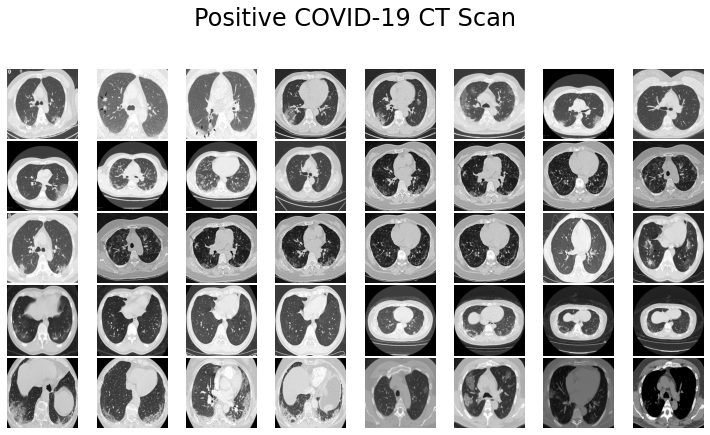

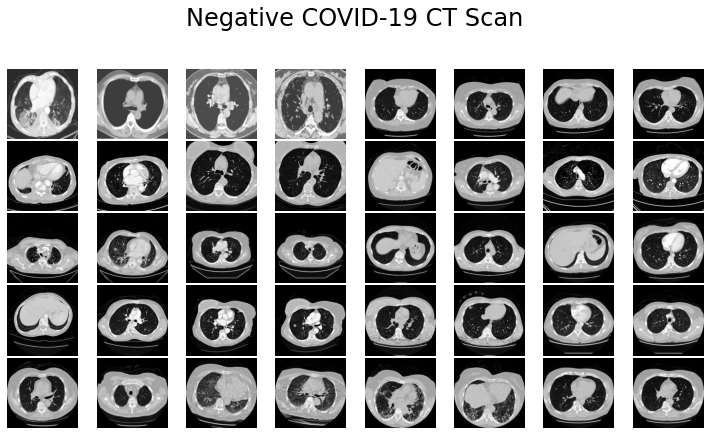

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [ ]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [ ]:
# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.4)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.4)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

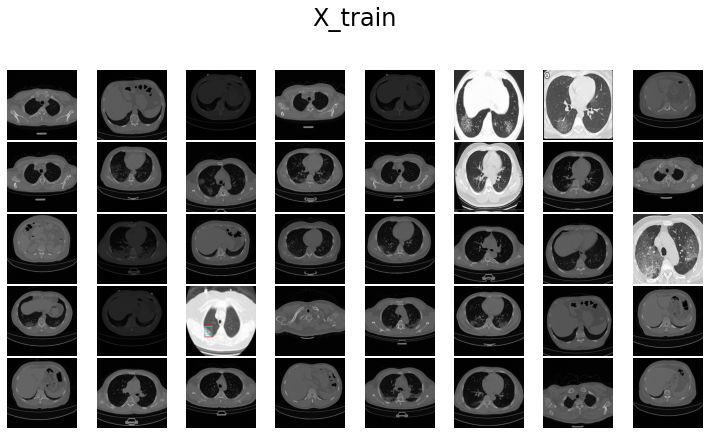

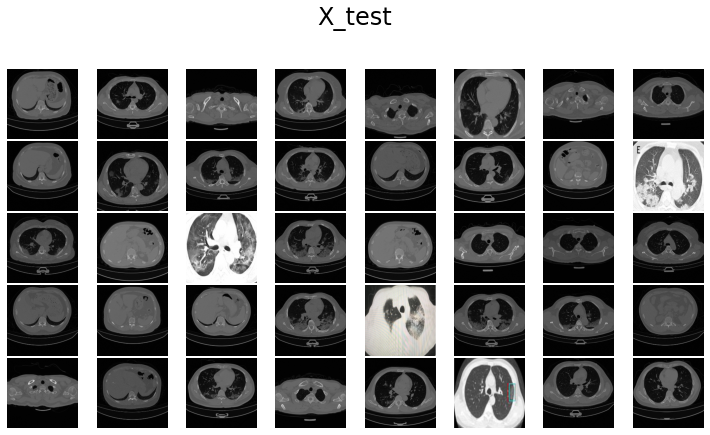

In [ ]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building and Visualizing model**

In [ ]:
# Building Model
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Visualize Model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### **Image Augmentation**
#### To train on images at different positions, angles, flips, etc

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/60
94/93 [==============================] - 413s 4s/step - loss: 0.4713 - accuracy: 0.8310 - val_loss: 0.2366 - val_accuracy: 0.9055
Epoch 2/60
94/93 [==============================] - 414s 4s/step - loss: 0.2579 - accuracy: 0.9137 - val_loss: 0.1695 - val_accuracy: 0.9360
Epoch 3/60
94/93 [==============================] - 412s 4s/step - loss: 0.2141 - accuracy: 0.9197 - val_loss: 0.2658 - val_accuracy: 0.9010
Epoch 4/60
94/93 [==============================] - 413s 4s/step - loss: 0.2031 - accuracy: 0.9223 - val_loss: 0.1954 - val_accuracy: 0.9300
Epoch 5/60
94/93 [==============================] - 412s 4s/step - loss: 0.2132 - accuracy: 0.9237 - val_loss: 0.3104 - val_accuracy: 0.8875
Epoch 6/60
94/93 [==============================] - 413s 4s/step - loss: 0.2371 - accuracy: 0.9203 - val_loss: 0.1963 - val_accuracy: 0.9340
Epoch 7/60
94/93 [==============================] - 414s 4s/step - loss: 0.2128 - accuracy: 0.9300 - val_loss: 0.1954 - val_accuracy: 0.9305
Epoch 8/60
94

Epoch 59/60
94/93 [==============================] - 416s 4s/step - loss: 0.2530 - accuracy: 0.9410 - val_loss: 0.2716 - val_accuracy: 0.9370
Epoch 60/60
94/93 [==============================] - 418s 4s/step - loss: 0.2352 - accuracy: 0.9440 - val_loss: 0.1797 - val_accuracy: 0.9500


In [ ]:
# Save Model and Weights
model.save('vgg_ct.h5')
model.save_weights('vgg_weights_ct.hdf5')

In [ ]:
# Load saved model
model = load_model('vgg_ct.h5')

### **Making Predicions**

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

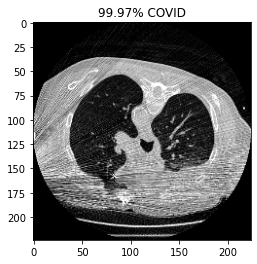

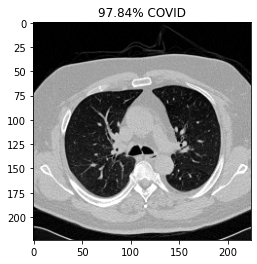

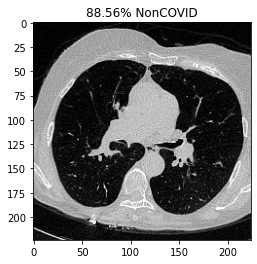

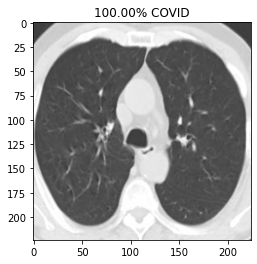

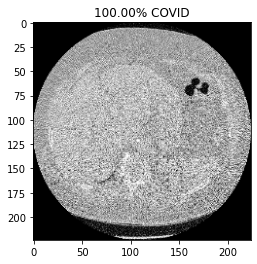

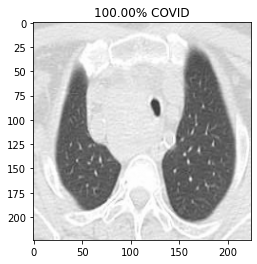

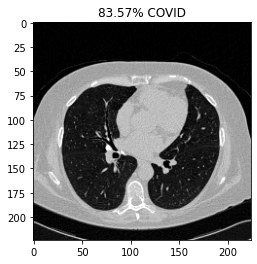

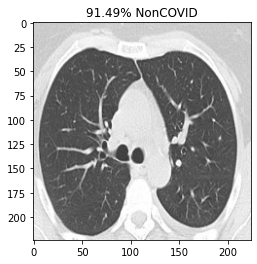

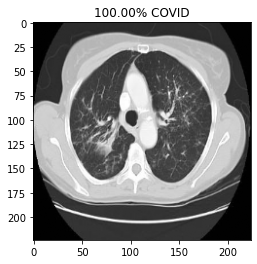

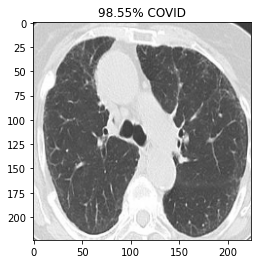

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

Auc= 95.00


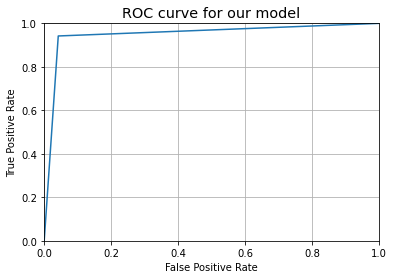

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
auc=metrics.auc(fpr,tpr)
print("Auc= {:.2f}".format(auc*100))

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)



### Plot Confusion Matrix

Confusion Matrix without Normalization


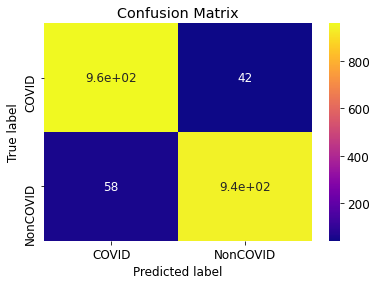

Confusion Matrix with Normalized Values


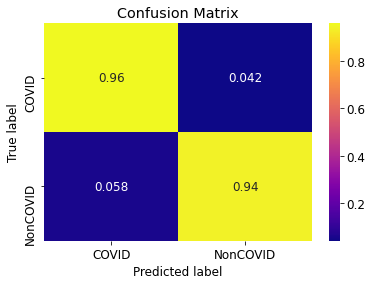

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1000
           1       0.96      0.94      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



### **Accuracy and Loss Plots**

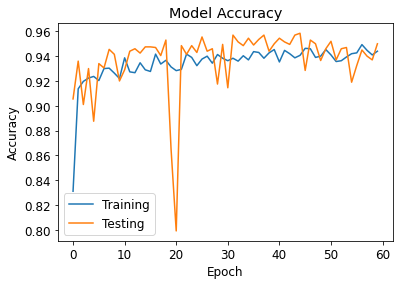

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()


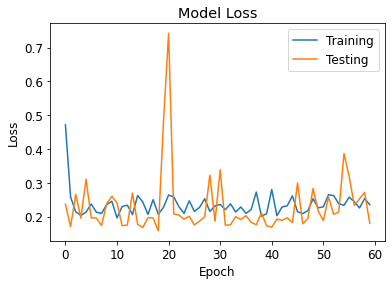

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_loss.png')
plt.show()